# Model 3:

### Target:

- Add `BatchNormalization` to increase model efficiency.


### Results:

- Parameters: 7,448
- Best Training Accuracy: 99.49
- Best Test Accuracy: 99.47

### Analysis:

- We have started to see over-fitting now as train and test accuracies are diverging. 
- Model is capable of reaching 99.47 accuracy in 15 epochs but can't be pushed further.

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import warnings
warnings.filterwarnings("ignore")

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
from utils import load_data

train, test = load_data(train_transforms, test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


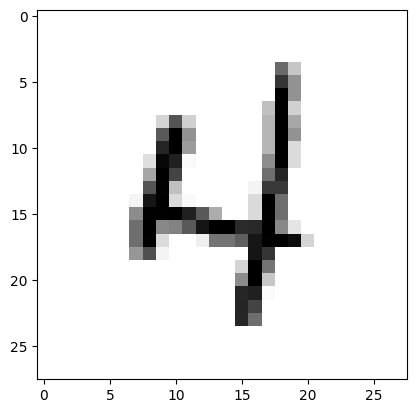

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

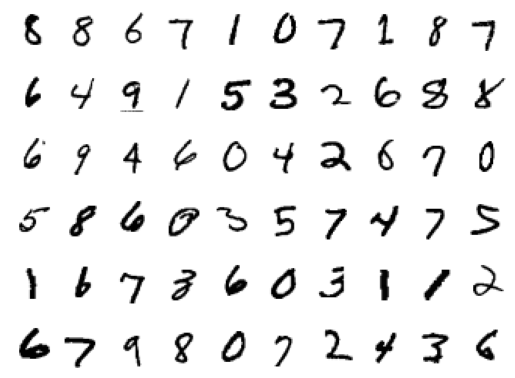

In [6]:
from utils import plot_images
plot_images(images)

# The model
Let's import our model from `model.py` file

In [7]:
from model import Model3 as Net

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7            [-1, 8, 24, 24]             128
       BatchNorm2d-8            [-1, 8, 24, 24]              16
              ReLU-9            [-1, 8, 24, 24]               0
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
      BatchNorm2d-12           [-1, 16, 10, 10]              32
             ReLU-13           [-1, 16, 10, 10]               0
           Conv2d-14              

# Training and Testing
Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's import train and test functions from `model.py` file

In [9]:
from model import train, test

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_losses = []
test_losses = []
train_acc = []
test_acc = []

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    test(model, device, test_loader, test_losses, test_acc)

EPOCH: 0


Loss=0.0749133825302124 Batch_id=468 Accuracy=88.88: 100%|███████████████████████████| 469/469 [00:06<00:00, 77.58it/s]



Test set: Average loss: 0.1007, Accuracy: 9758/10000 (97.58%)

EPOCH: 1


Loss=0.13057027757167816 Batch_id=468 Accuracy=98.22: 100%|██████████████████████████| 469/469 [00:05<00:00, 82.30it/s]



Test set: Average loss: 0.0462, Accuracy: 9879/10000 (98.79%)

EPOCH: 2


Loss=0.031999025493860245 Batch_id=468 Accuracy=98.56: 100%|█████████████████████████| 469/469 [00:05<00:00, 80.79it/s]



Test set: Average loss: 0.0371, Accuracy: 9894/10000 (98.94%)

EPOCH: 3


Loss=0.013974021188914776 Batch_id=468 Accuracy=98.85: 100%|█████████████████████████| 469/469 [00:06<00:00, 77.30it/s]



Test set: Average loss: 0.0334, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.01187072228640318 Batch_id=468 Accuracy=98.97: 100%|██████████████████████████| 469/469 [00:06<00:00, 76.87it/s]



Test set: Average loss: 0.0318, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.017430054023861885 Batch_id=468 Accuracy=99.02: 100%|█████████████████████████| 469/469 [00:05<00:00, 81.64it/s]



Test set: Average loss: 0.0313, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.025034138932824135 Batch_id=468 Accuracy=99.09: 100%|█████████████████████████| 469/469 [00:05<00:00, 78.96it/s]



Test set: Average loss: 0.0281, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.05110219120979309 Batch_id=468 Accuracy=99.19: 100%|██████████████████████████| 469/469 [00:05<00:00, 78.30it/s]



Test set: Average loss: 0.0257, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.037183742970228195 Batch_id=468 Accuracy=99.27: 100%|█████████████████████████| 469/469 [00:05<00:00, 79.63it/s]



Test set: Average loss: 0.0285, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.051321644335985184 Batch_id=468 Accuracy=99.24: 100%|█████████████████████████| 469/469 [00:05<00:00, 78.61it/s]



Test set: Average loss: 0.0263, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss=0.011859830468893051 Batch_id=468 Accuracy=99.33: 100%|█████████████████████████| 469/469 [00:05<00:00, 78.44it/s]



Test set: Average loss: 0.0264, Accuracy: 9914/10000 (99.14%)

EPOCH: 11


Loss=0.0388265959918499 Batch_id=468 Accuracy=99.34: 100%|███████████████████████████| 469/469 [00:05<00:00, 78.28it/s]



Test set: Average loss: 0.0262, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.0038295930717140436 Batch_id=468 Accuracy=99.35: 100%|████████████████████████| 469/469 [00:06<00:00, 77.74it/s]



Test set: Average loss: 0.0223, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.04862493649125099 Batch_id=468 Accuracy=99.45: 100%|██████████████████████████| 469/469 [00:05<00:00, 78.40it/s]



Test set: Average loss: 0.0202, Accuracy: 9947/10000 (99.47%)

EPOCH: 14


Loss=0.02709210477769375 Batch_id=468 Accuracy=99.49: 100%|██████████████████████████| 469/469 [00:05<00:00, 79.06it/s]



Test set: Average loss: 0.0246, Accuracy: 9920/10000 (99.20%)



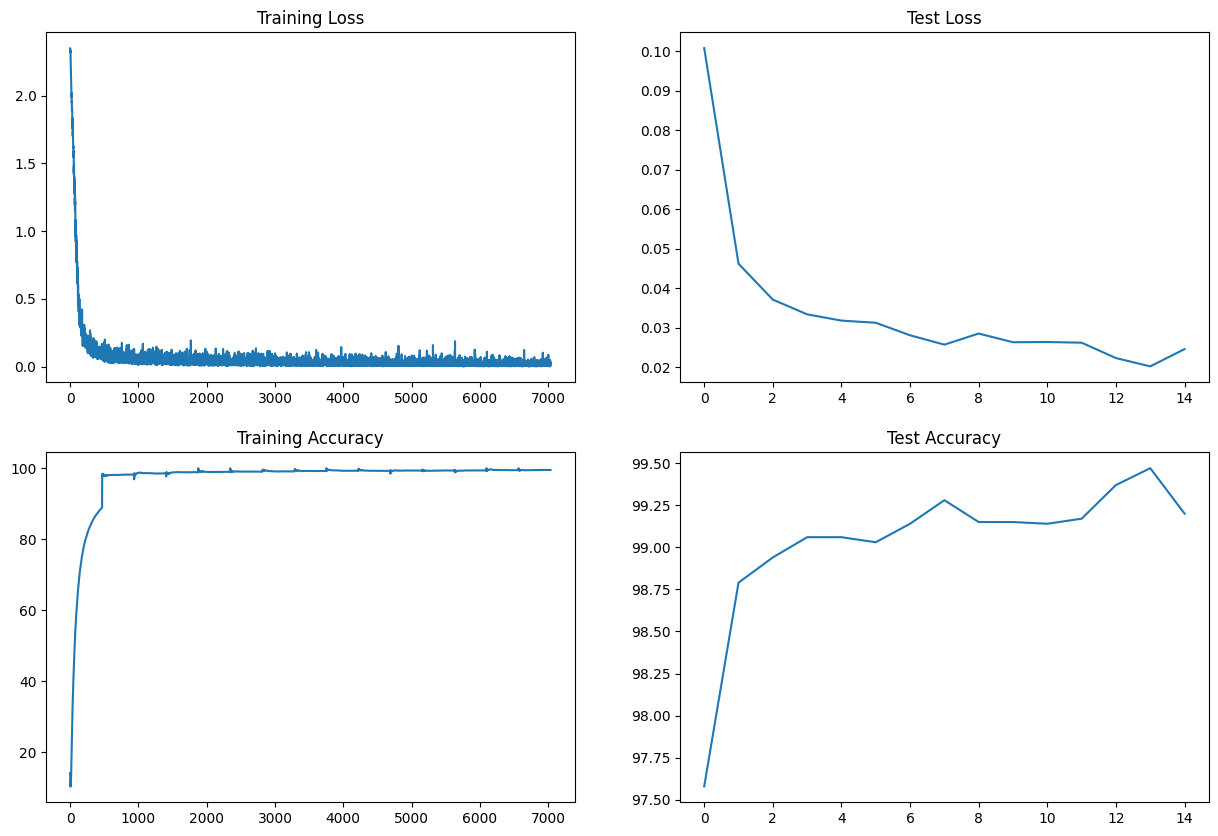

In [11]:
from utils import plot_graphs

plot_graphs(train_acc, train_losses, test_acc, test_losses)